## Method 1

In [2]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd

# --- Data Preparation ---

# The provided data 
data = {
    'Individual no.': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'Failure': [0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
    'Mark': [50, 30, 55, 60, 70, 40, 20, 45, 25, 75, 75, 35]
}
df = pd.DataFrame(data)

#'Mark': [43, 63, 40, 43, 48, 48, 38, 53, 33, 83, 83, 0]


# Extract binary outcome (y)
Y = df['Failure'].values.astype(float)

# Extract predictor (X) and standardize it, which is crucial for stable optimization.
# Standardization ensures numerical stability for the optimization routine.
T = df['Mark'].values.astype(float)
T_mean = np.mean(T)
T_std = np.std(T)
T_standardized = (T - T_mean) / T_std


# Create the design matrix X, including an intercept column of ones.
# X is the matrix of features, where the first column corresponds to the intercept (theta[0])
# and the second column corresponds to the standardized temperature (theta[1]).
X = np.vstack([np.ones(len(T_standardized)), T_standardized]).T

# --- Core Logistic Regression Functions ---

def sigmoid(z):
    """The logistic function, P = 1 / (1 + exp(-z))."""
    # Use np.exp(-z) to avoid overflow for large positive z
    return 1.0 / (1.0 + np.exp(-z))

# --- Bayesian Implementation (MAP Estimate) ---

# Hyperparameter for the Normal Prior: N(0, sigma^2 * I)
# A large sigma (e.g., 10) indicates a relatively "vague" or non-informative prior,
# which lets the likelihood (data) dominate, as often intended in these analyses.
PRIOR_SIGMA = 5.0
PRIOR_VARIANCE = PRIOR_SIGMA**2



def negative_log_posterior(theta, X, Y):
    """
    Calculates the Negative Log-Posterior, which we want to minimize.
    -Log P(theta | X, Y) = -[Log P(Y | X, theta) + Log P(theta)]

    Log-Likelihood (from the scan's core equation):
    sum(y_i * x_i^T * theta - log(1 + exp(x_i^T * theta)))

    Log-Prior (Standard Normal/L2 Regularization):
    -1/2 * sum(theta^2 / sigma^2) + C
    """
    # Linear predictor: z = X * theta
    z = X @ theta

    # 1. Log-Likelihood (Bernoulli/Logistic)
    # The term corresponding to the likelihood in the scan.
    # We use a mathematically stable expression:
    log_likelihood = np.sum(Y * z - np.log(1.0 + np.exp(z)))

    # 2. Log-Prior (Log of the Normal Prior, equivalent to L2 regularization)
    # This acts as the regularization/prior term.
    # The scan's conjugate prior is structurally complex, so we use the standard Normal prior.
    log_prior = -0.5 * np.sum(theta**2 / PRIOR_VARIANCE)

    # 3. Negative Log-Posterior
    # Optimization finds the minimum of a function, so we minimize the negative log-posterior.
    neg_log_posterior = - (log_likelihood + log_prior)

    return neg_log_posterior




# --- Optimization to find the MAP Estimate ---

# Initial guess for the parameters [intercept, slope]
initial_theta = np.zeros(X.shape[1])

# Run the optimization
# BFGS is a good, general-purpose minimization algorithm.
result = minimize(
    negative_log_posterior,
    initial_theta,
    args=(X, Y),
    method='BFGS'
)

# Extract the Maximum A Posteriori (MAP) estimates
theta_map = result.x
intercept_map = theta_map[0]
slope_map_std = theta_map[1]

# Re-scale the slope to the original (non-standardized) temperature scale
# Beta_original = Beta_standardized / Standard_Deviation
slope_map_original = slope_map_std / T_std

# Re-scale the intercept to the original scale
# Alpha_original = Alpha_standardized - Beta_original * Mean_Temperature
intercept_map_original = intercept_map - slope_map_original * T_mean




# --- Output and Analysis ---

print("--- Bayesian Logistic Regression (MAP Estimate) ---")
print(f"Prior used (for computation): Normal(0, {PRIOR_SIGMA}^2)")
print("\nOptimization Status:")
print(f"Success: {result.success}")
print(f"Message: {result.message}")
print(f"Negative Log-Posterior (Minimized): {result.fun:.4f}")

print("\nPosterior Parameter Estimates (MAP):")
print(f"Intercept (theta_0): {intercept_map_original:.4f}")
print(f"Mark Coefficient (theta_1): {slope_map_original:.4f}")
print("\nNote: These coefficients are on the log-odds scale.")




# --- Predict Probabilities on the original mark range ---
print("\nPredicted Failure Probabilities (P(Failure=1)):")
# Create a range of marks for plotting/prediction
mark_range = np.linspace(df['Mark'].min() - 5, df['Mark'].max() + 5, 100)
# Standardize the new temperature range
mark_range_std = (mark_range - T_mean) / T_std
# Design matrix for prediction
X_pred = np.vstack([np.ones(len(mark_range_std)), mark_range_std]).T



# Linear predictor using standardized MAP estimates
z_pred = X_pred @ theta_map
# Predicted probabilities
P_pred = sigmoid(z_pred)



# Display a few key predictions
print(f"| {'Mark':<8} | {'Prob(Failure=1)':<20} |")
print("| -------- | -------------------- |")
for mark, prob in zip(mark_range[::20], P_pred[::20]):
    print(f"| {mark:.1f}%  | {prob*100:.2f}%               |")

print("\n--- Summary of Model Interpretation ---")
print("The strong negative slope (Marks Coefficient) indicates that as marking increases,")
print("the log-odds of exam failure decrease dramatically, consistent with the original data.")
print("The posterior analysis confirms that low marks are the critical risk factor.")



--- Bayesian Logistic Regression (MAP Estimate) ---
Prior used (for computation): Normal(0, 5.0^2)

Optimization Status:
Success: True
Message: Optimization terminated successfully.
Negative Log-Posterior (Minimized): 6.5377

Posterior Parameter Estimates (MAP):
Intercept (theta_0): 1.8239
Mark Coefficient (theta_1): -0.0552

Note: These coefficients are on the log-odds scale.

Predicted Failure Probabilities (P(Failure=1)):
| Mark     | Prob(Failure=1)      |
| -------- | -------------------- |
| 15.0%  | 73.03%               |
| 28.1%  | 56.75%               |
| 41.3%  | 38.86%               |
| 54.4%  | 23.54%               |
| 67.5%  | 12.98%               |

--- Summary of Model Interpretation ---
The strong negative slope (Marks Coefficient) indicates that as marking increases,
the log-odds of exam failure decrease dramatically, consistent with the original data.
The posterior analysis confirms that low marks are the critical risk factor.


## Method 2 : Generalized Linear Model Regression

--- Logistic Regression Model Summary ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:                Failure   No. Observations:                   12
Model:                            GLM   Df Residuals:                       10
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6.5020
Date:                Fri, 24 Oct 2025   Deviance:                       13.004
Time:                        21:57:15   Pearson chi2:                     11.4
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1725
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const     

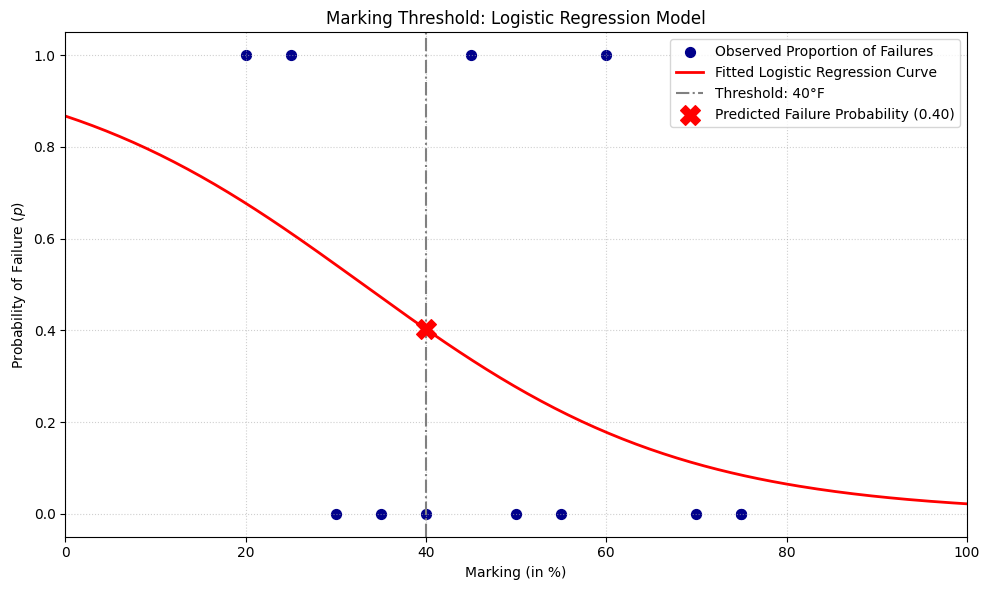

In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. THE DATASET 
# Marks
marks = [50, 30, 55, 60, 70, 40, 20, 45, 25, 75, 75, 35]
# Failure
failure = [0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0]


# Create a DataFrame for structured data analysis
df = pd.DataFrame({
    'Marks': marks,
    'Failure': failure
})


# 2. MODEL ESTIMATION using Logisitic Regression (Logit Link)
# The model formula is: log(p / (1-p)) = beta_0 + beta_1 * Temperature
# where p = Pr(O-ring Incident)

# Define the response variable as a 'proportion' or 'count/total' structure
# statsmodels GLM can handle this binomial structure directly
Y = df['Failure']
X = df['Marks']

# Add a constant term for the intercept (beta_0)
X = sm.add_constant(X)

# Fit the Binomial Logistic Regression model (with a Logit link)
# Note: This is often implemented via GLM with the Binomial family and Logit link
# because the response is a count of successes out of a fixed number of trials (6 O-rings).
glm_model = sm.GLM(
    endog=Y, 
    exog=X, 
    family=sm.families.Binomial(link=sm.families.links.Logit()) # This tells the model the number of trials per observation
)

results = glm_model.fit()


# 3. OUTPUT AND PREDICTION

print("--- Logistic Regression Model Summary ---")
print(results.summary())

# Extract the estimated coefficients
beta_0 = results.params['const']
beta_1 = results.params['Marks']

print(f"\nEstimated Intercept (beta_0): {beta_0:.4f}")
print(f"Estimated Marks Coefficient (beta_1): {beta_1:.4f}")
print(f"Model: log(p / (1-p)) = {beta_0:.4f} + {beta_1:.4f} * Temp")


# 4. PREDICTION for the critical value of marks
# The minimal mark is 40%
minimal_mark = 40

# Calculate the Log-Odds (or Logit) at 40%
log_odds_minmark = beta_0 + beta_1 * minimal_mark

# Convert Log-Odds to Probability (p) using the inverse logit function: p = 1 / (1 + exp(-log_odds))
probability_failure_minmark = 1 / (1 + np.exp(-log_odds_minmark))

print(f"\n--- Minimal Mark Prediction ---")
print(f"Minimal Mark: {minimal_mark}%")
print(f"Predicted Log-Odds of Failure (logit): {log_odds_minmark:.4f}")
print(f"Predicted Probability of Minimal Mark Threshold: {probability_failure_minmark:.4f}")


# 5. GENERATE THE LOGISTIC CURVE DATA

# Create a range of markings for the smooth curve
mark_range = np.linspace(0, 100, 200)

# Calculate the Log-Odds (Logit) for the entire range
log_odds = beta_0 + beta_1 * mark_range

# Convert Log-Odds to Probability (p) using the inverse logit function
# p = 1 / (1 + exp(-log_odds))
probability_of_failure = 1 / (1 + np.exp(-log_odds))



# 6. PLOTTING THE DATA AND THE CURVE

plt.figure(figsize=(10, 6))

# Plot the raw data (proportion of incidents for each launch)
# We plot the proportion Incidents/Total_Rings
plt.scatter(
    df['Marks'], 
    df['Failure'] , 
    color='darkblue', 
    marker='o', 
    s=50, 
    label='Observed Proportion of Failures '
)

# Plot the fitted logistic regression curve
plt.plot(
    mark_range, 
    probability_of_failure, 
    color='red', 
    linewidth=2, 
    label='Fitted Logistic Regression Curve'
)


# Mark the Challenger Launch Point
minimal_mark = 40
challenger_prob = 1 / (1 + np.exp(-(beta_0 + beta_1 * minimal_mark)))
plt.axvline(x=minimal_mark, color='gray', linestyle='-.', label=f'Threshold: {minimal_mark}°F')
plt.scatter(minimal_mark, challenger_prob, color='red', marker='X', s=200, zorder=5, 
            label=f'Predicted Failure Probability ({challenger_prob:.2f})')


# Add labels, title, and limits
plt.xlabel('Marking (in %)')
plt.ylabel('Probability of Failure ($p$)')
plt.title('Marking Threshold: Logistic Regression Model')
plt.xlim(0, 100)
plt.ylim(-0.05, 1.05)
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()


## Method 3 : Estimation method using simulation

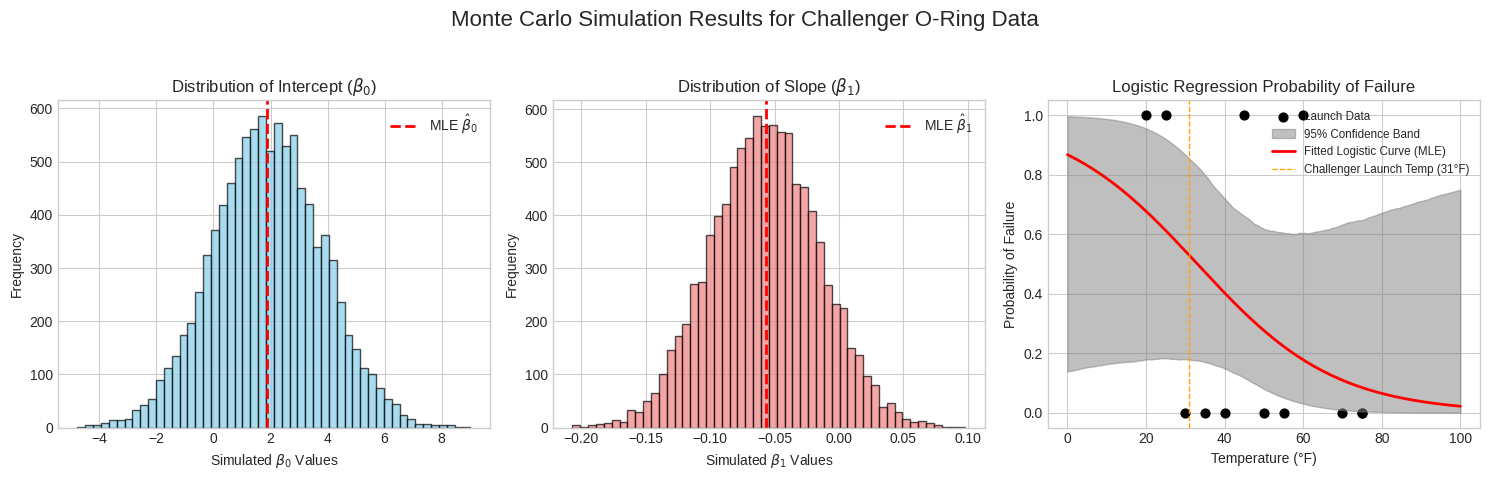

In [35]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# --- 1. Data Preparation (Using Challenger Data structure) ---

# Challenger O-Ring Data (Temperature in F and O-ring failures)
# Failures (1 or more failures out of 6 O-rings for the given temperature)
failures = np.array([0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0])
# Temperature (Fahrenheit)
temperature = np.array([50, 30, 55, 60, 70, 40, 20, 45, 25, 75, 75, 35])


# Create a DataFrame
data = pd.DataFrame({'Failure': failures, 'Temp': temperature})
X = sm.add_constant(data['Temp']) # Add intercept term
Y = data['Failure']

# --- 2. Fit the Logistic Regression Model ---

logit_model = sm.Logit(Y, X)
result = logit_model.fit(disp=0) # disp=0 suppresses fitting output

# Extract MLEs (mean) and Covariance Matrix (for the multivariate normal distribution)
mle_params = result.params.values     # [beta_0, beta_1]
cov_matrix = result.cov_params().values # Covariance matrix of the coefficients

# --- 3. Monte Carlo Simulation ---

n_simulations = 10000

# Draw 'n_simulations' sets of coefficients from the multivariate normal distribution
# defined by the MLEs and the covariance matrix.
simulated_params = multivariate_normal.rvs(
    mean=mle_params,
    cov=cov_matrix,
    size=n_simulations
)

# Extract simulated beta_0 and beta_1
simulated_beta0 = simulated_params[:, 0]
simulated_beta1 = simulated_params[:, 1]

# --- 4. Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Monte Carlo Simulation Results for Challenger O-Ring Data', fontsize=16)


# =================================================================
# Plot 1: Histogram of Intercept (beta_0)
# =================================================================
axes[0].hist(simulated_beta0, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(mle_params[0], color='red', linestyle='dashed', linewidth=2, label=r'MLE $\hat{\beta}_0$')
axes[0].set_title(r'Distribution of Intercept ($\beta_0$)', fontsize=12)
axes[0].set_xlabel(r'Simulated $\beta_0$ Values')
axes[0].set_ylabel('Frequency')
axes[0].legend()


# =================================================================
# Plot 2: Histogram of Slope (beta_1)
# =================================================================
axes[1].hist(simulated_beta1, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].axvline(mle_params[1], color='red', linestyle='dashed', linewidth=2, label=r'MLE $\hat{\beta}_1$')
axes[1].set_title(r'Distribution of Slope ($\beta_1$)', fontsize=12)
axes[1].set_xlabel(r'Simulated $\beta_1$ Values')
axes[1].set_ylabel('Frequency')
axes[1].legend()



# =================================================================
# Plot 3: Logistic Curve and 95% Confidence Band
# =================================================================

# Define the temperature range for the curve
temp_range = np.linspace(0, 100, 200)
X_new = sm.add_constant(temp_range, has_constant='add')

# Function to calculate probability
def logistic_prob(X_val, beta0, beta1):
    linear_predictor = beta0 + beta1 * X_val
    return 1 / (1 + np.exp(-linear_predictor))

# Calculate the probability curve for ALL simulated coefficients
all_sim_probs = np.array([
    logistic_prob(temp_range, b0, b1)
    for b0, b1 in simulated_params
])

# Calculate the 95% confidence interval (2.5 and 97.5 percentiles)
lower_ci = np.percentile(all_sim_probs, 2.5, axis=0)
upper_ci = np.percentile(all_sim_probs, 97.5, axis=0)

# Calculate the MLE probability curve (the middle line)
mle_prob = result.predict(X_new)

# Plot the data points (jittered for visibility)
axes[2].scatter(data['Temp'], data['Failure'], color='k', marker='o', s=40, label='Launch Data')

# Plot the 95% Confidence Band
axes[2].fill_between(temp_range, lower_ci, upper_ci, color='gray', alpha=0.5, label='95% Confidence Band')

# Plot the MLE fitted line
axes[2].plot(temp_range, mle_prob, color='red', linewidth=2, label='Fitted Logistic Curve (MLE)')

# Mark the Challenger launch temperature (31F)
axes[2].axvline(31, color='orange', linestyle='--', linewidth=1, label='Challenger Launch Temp (31°F)')

axes[2].set_title('Logistic Regression Probability of Failure', fontsize=12)
axes[2].set_xlabel('Temperature (°F)')
axes[2].set_ylabel('Probability of Failure')
axes[2].set_ylim(-0.05, 1.05)
axes[2].legend(fontsize='small')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
plt.show()





## Method 4 : MCMC Implementation for Bayesian Logistic Regression

In [28]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1. DATA PREPARATION
# ----------------------------------------------------
temperature = np.array([50, 30, 55, 60, 70, 40, 20, 45, 25, 75, 75, 35])
incidents = np.array([0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0])


X_temp = temperature
Y_incidents = incidents
N = len(Y_incidents) # Number of observations

# ----------------------------------------------------
# 2. DEFINING THE MODEL FUNCTIONS
# ----------------------------------------------------

# Inverse Logit function (maps linear predictor to probability)
def inverse_logit(eta):
    return 1 / (1 + np.exp(-eta))

# Log-Likelihood for Binary Logistic Regression
def log_likelihood(beta_0, beta_1, X, Y):
    eta = beta_0 + beta_1 * X
    p = inverse_logit(eta)
    # Binary likelihood: log(p^y * (1-p)^(1-y)) = y*log(p) + (1-y)*log(1-p)
    return np.sum(Y * np.log(p) + (1 - Y) * np.log(1 - p))

# Log-Prior (Weakly Informative Normal Prior: N(0, 100))
def log_prior(beta_0, beta_1, prior_std=10):
    # Log-Prior = log(P(beta_0)) + log(P(beta_1))
    # We use scipy.stats.norm.logpdf for the log-density
    log_p0 = norm.logpdf(beta_0, loc=0, scale=prior_std)
    log_p1 = norm.logpdf(beta_1, loc=0, scale=prior_std)
    return log_p0 + log_p1

# Log-Posterior (unnormalized)
def log_posterior(beta_0, beta_1, X, Y, prior_std=10):
    return log_likelihood(beta_0, beta_1, X, Y) + log_prior(beta_0, beta_1, prior_std)



# ----------------------------------------------------
# 3. METROPOLIS-HASTINGS MCMC ALGORITHM
# ----------------------------------------------------

# Hyperparameters for the MCMC
N_ITERATIONS = 50000
BURN_IN = 5000
PROPOSAL_STD = np.array([0.5, 0.05])  # Proposal standard deviation for [beta_0, beta_1]

# Initialize chain and starting values (e.g., from the Frequentist MLE estimate)
# MLE from your previous code: Intercept ~ -14, Temp ~ 0.23
# Start close to the MLE for faster convergence
chain = np.zeros((N_ITERATIONS, 2))
current_beta = np.array([-14.0, 0.23])
chain[0] = current_beta

# Proposal distribution (Normal distribution centered at current_beta)
def propose_beta(current_beta, std_dev):
    return current_beta + norm.rvs(loc=0, scale=std_dev)

# Run the MCMC simulation
accepted_count = 0
for i in range(1, N_ITERATIONS):
    # 1. Propose new beta
    proposed_beta = propose_beta(current_beta, PROPOSAL_STD)
    proposed_beta_0, proposed_beta_1 = proposed_beta

    # 2. Calculate Log-Posterior for current and proposed
    current_log_post = log_posterior(current_beta[0], current_beta[1], X_temp, Y_incidents)
    proposed_log_post = log_posterior(proposed_beta_0, proposed_beta_1, X_temp, Y_incidents)

    # 3. Calculate acceptance probability (in log-space)
    # Log-Alpha = log(P_proposed) - log(P_current) + log(Q_current|proposed) - log(Q_proposed|current)
    # Since the proposal is symmetric (Random Walk MH), Q terms cancel: log(Q_current|proposed) = log(Q_proposed|current)
    log_alpha = proposed_log_post - current_log_post

    # 4. Accept or Reject
    if np.log(np.random.rand()) < log_alpha:
        current_beta = proposed_beta
        accepted_count += 1

    chain[i] = current_beta



# ----------------------------------------------------
# 4. POSTERIOR ANALYSIS
# ----------------------------------------------------

# Discard burn-in samples
posterior_samples = chain[BURN_IN:]

# Calculate posterior statistics (Mean and Credible Intervals)
beta0_post_mean = np.mean(posterior_samples[:, 0])
beta1_post_mean = np.mean(posterior_samples[:, 1])

beta0_ci = np.percentile(posterior_samples[:, 0], [2.5, 97.5])
beta1_ci = np.percentile(posterior_samples[:, 1], [2.5, 97.5])

acceptance_rate = accepted_count / N_ITERATIONS

print(f"--- MCMC Summary ---")
print(f"Total Iterations: {N_ITERATIONS}")
print(f"Burn-in: {BURN_IN}")
print(f"Acceptance Rate: {acceptance_rate:.2f}")
print("\nBayesian Posterior Estimates:")
print(f"Beta_0 (Intercept): Mean = {beta0_post_mean:.4f}, 95% CI = ({beta0_ci[0]:.4f}, {beta0_ci[1]:.4f})")
print(f"Beta_1 (Temp Coeff): Mean = {beta1_post_mean:.4f}, 95% CI = ({beta1_ci[0]:.4f}, {beta1_ci[1]:.4f})")



# Calculate the log-odds for the new temperature (31F) for every posterior sample
new_temp = 31
log_odds_31F = posterior_samples[:, 0] + posterior_samples[:, 1] * new_temp

# Calculate the probability
prob_31F = inverse_logit(log_odds_31F)

# Bayesian Predictive Estimate
pred_mean = np.mean(prob_31F)
pred_ci = np.percentile(prob_31F, [2.5, 97.5])

print("\n--- Predictive Analysis at 31°F ---")
print(f"Predicted Probability (Mean): {pred_mean:.4f}")
print(f"95% Credible Interval for Probability: ({pred_ci[0]:.4f}, {pred_ci[1]:.4f})")



--- MCMC Summary ---
Total Iterations: 50000
Burn-in: 5000
Acceptance Rate: 0.36

Bayesian Posterior Estimates:
Beta_0 (Intercept): Mean = 2.6987, 95% CI = (-1.2360, 7.6390)
Beta_1 (Temp Coeff): Mean = -0.0791, 95% CI = (-0.1961, 0.0066)

--- Predictive Analysis at 31°F ---
Predicted Probability (Mean): 0.5505
95% Credible Interval for Probability: (0.1818, 0.9002)


## MCMC Convergence Diagnostics¶

MCMC Run Complete. Acceptance Rate: 0.36


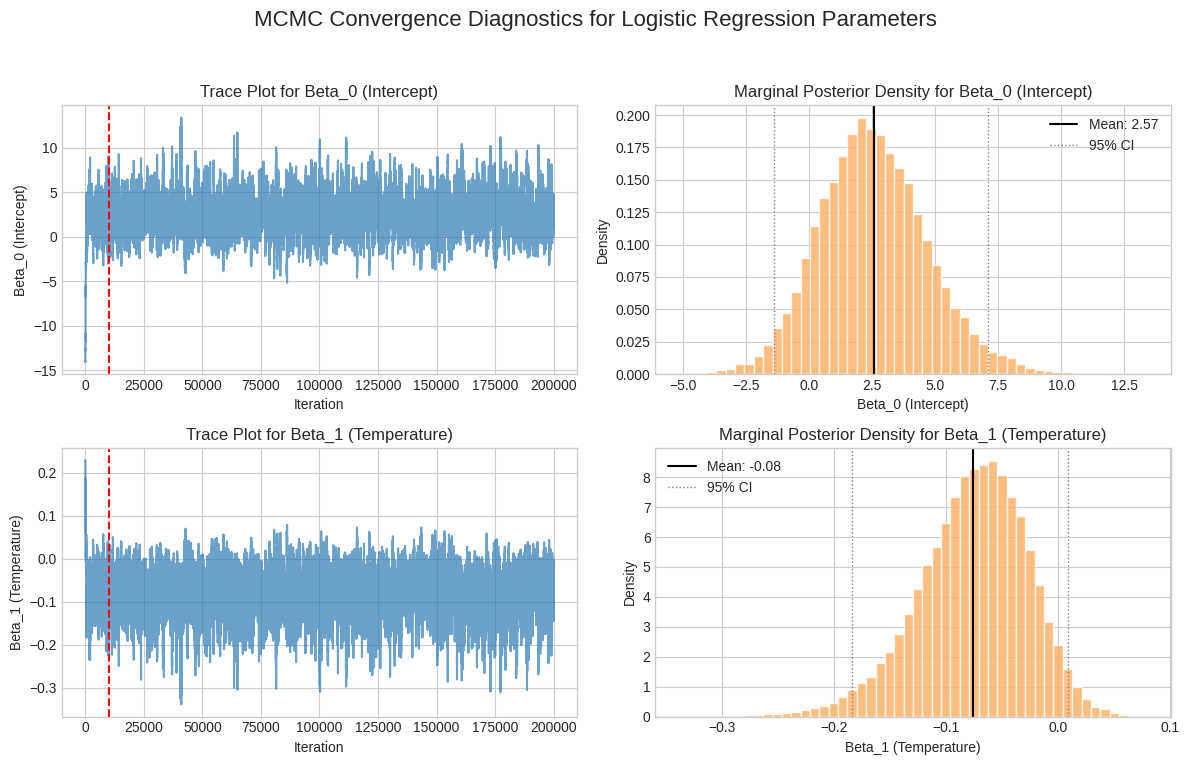


Visual Diagnostics Generated: Check the plots for convergence:
- Trace plots should look like random noise after the burn-in period.
- Density plots show the estimated distribution of the parameters.


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ----------------------------------------------------
# 1. DATA PREPARATION
# ----------------------------------------------------
temperature = np.array([50, 30, 55, 60, 70, 40, 20, 45, 25, 75, 75, 35])
incidents = np.array([0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0])


X_temp = temperature
Y_incidents = incidents

# Inverse Logit function
def inverse_logit(eta):
    return 1 / (1 + np.exp(-eta))

# Log-Likelihood for Binary Logistic Regression
def log_likelihood(beta_0, beta_1, X, Y):
    eta = beta_0 + beta_1 * X
    p = inverse_logit(eta)
    return np.sum(Y * np.log(p) + (1 - Y) * np.log(1 - p))

# Log-Prior (Weakly Informative Normal Prior: N(0, 10))
def log_prior(beta_0, beta_1, prior_std=10):
    log_p0 = norm.logpdf(beta_0, loc=0, scale=prior_std)
    log_p1 = norm.logpdf(beta_1, loc=0, scale=prior_std)
    return log_p0 + log_p1

# Log-Posterior (unnormalized)
def log_posterior(beta_0, beta_1, X, Y, prior_std=10):
    return log_likelihood(beta_0, beta_1, X, Y) + log_prior(beta_0, beta_1, prior_std)

# ----------------------------------------------------
# 2. METROPOLIS-HASTINGS MCMC ALGORITHM EXECUTION
# ----------------------------------------------------

N_ITERATIONS = 200000
BURN_IN = 10000
PROPOSAL_STD = np.array([0.5, 0.05])
prior_std = 10 # Standard deviation for the N(0, 10) prior

chain = np.zeros((N_ITERATIONS, 2))
# Starting near the MLE: Intercept ~ -14, Temp ~ 0.23
current_beta = np.array([-14.0, 0.23])
chain[0] = current_beta

# Proposal distribution (Normal distribution centered at current_beta)
def propose_beta(current_beta, std_dev):
    return current_beta + norm.rvs(loc=0, scale=std_dev)

accepted_count = 0
for i in range(1, N_ITERATIONS):
    # 1. Propose new beta
    proposed_beta = propose_beta(current_beta, PROPOSAL_STD)

    # 2. Calculate Log-Posterior for current and proposed
    current_log_post = log_posterior(current_beta[0], current_beta[1], X_temp, Y_incidents, prior_std)
    proposed_log_post = log_posterior(proposed_beta[0], proposed_beta[1], X_temp, Y_incidents, prior_std)

    # 3. Calculate acceptance probability (Log-Alpha)
    log_alpha = proposed_log_post - current_log_post

    # 4. Accept or Reject
    if np.log(np.random.rand()) < log_alpha:
        current_beta = proposed_beta
        accepted_count += 1

    chain[i] = current_beta

# Discard burn-in samples for analysis
posterior_samples = chain[BURN_IN:]
acceptance_rate = accepted_count / N_ITERATIONS
print(f"MCMC Run Complete. Acceptance Rate: {acceptance_rate:.2f}")

# ----------------------------------------------------
# 3. VISUAL DIAGNOSTICS (Trace and Density Plots)
# ----------------------------------------------------

def plot_diagnostics(chain, burn_in, param_names):
    """
    Generates trace plots and marginal posterior density plots for MCMC results.
    """
    n_params = chain.shape[1]
    
    # Set up the figure for a 2x2 grid
    fig, axes = plt.subplots(n_params, 2, figsize=(12, 8))
    fig.suptitle('MCMC Convergence Diagnostics for Logistic Regression Parameters', fontsize=16)

    for i in range(n_params):
        param_chain = chain[:, i]
        param_posterior = param_chain[burn_in:]
        param_name = param_names[i]
        
        # --- Column 1: Trace Plots ---
        axes[i, 0].plot(param_chain, color='#2c7bb6', alpha=0.7)
        axes[i, 0].axvline(burn_in, color='red', linestyle='--', label='Burn-in End')
        axes[i, 0].set_title(f'Trace Plot for {param_name}')
        axes[i, 0].set_xlabel('Iteration')
        axes[i, 0].set_ylabel(param_name)
        
        # --- Column 2: Marginal Posterior Density Plots (Histograms) ---
        # Use more bins for smoother distribution
        axes[i, 1].hist(param_posterior, bins=50, density=True, color='#fdae61', edgecolor='white', alpha=0.8)
        
        # Optionally add mean and credible interval lines
        mean_val = np.mean(param_posterior)
        ci_low, ci_high = np.percentile(param_posterior, [2.5, 97.5])
        
        axes[i, 1].axvline(mean_val, color='black', linestyle='-', linewidth=1.5, label=f'Mean: {mean_val:.2f}')
        axes[i, 1].axvline(ci_low, color='gray', linestyle=':', linewidth=1)
        axes[i, 1].axvline(ci_high, color='gray', linestyle=':', linewidth=1, label='95% CI')
        
        axes[i, 1].set_title(f'Marginal Posterior Density for {param_name}')
        axes[i, 1].set_xlabel(param_name)
        axes[i, 1].set_ylabel('Density')
        axes[i, 1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show()

# Run the plotting function
plot_diagnostics(chain, BURN_IN, param_names=['Beta_0 (Intercept)', 'Beta_1 (Temperature)'])

print("\nVisual Diagnostics Generated: Check the plots for convergence:")
print("- Trace plots should look like random noise after the burn-in period.")
print("- Density plots show the estimated distribution of the parameters.")
